In [14]:
from torchvision.datasets import CIFAR10

In [15]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from PIL import Image

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# 3.1

In [17]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [18]:
data_dir = './cifar10'
train_set = CIFAR10(data_dir, train=True, download=True, transform=transform)
test_set = CIFAR10(data_dir, train=False, download=True, transform=transform)

trainloader = DataLoader(train_set, batch_size=20, shuffle=True)
testloader = DataLoader(test_set, batch_size=20, shuffle=True)

classes = train_set.classes
print(f"Classes: {classes}")

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 3.2

In [19]:
# defining out CNN

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # input is 150 x 150 x 3

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 10) # 10 output classes for CIFAR-10
        )

        self.flatten = nn.Flatten()
        

    def forward(self, x):
        # conv layers with norm and pooling
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # flatten
        x = self.flatten(x)

        # feed into fc layer
        x = self.fc(x)

        return x


In [20]:
model = CNN().to(device)

print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=41472, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p

In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the model on the validation set
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')

torch.save(model.state_dict(), '3model.pth')

Epoch [1/15], Loss: 2.069095687484741, Accuracy: 25.548%
Validation Accuracy: 42.68%
Epoch [2/15], Loss: 1.6088279689311982, Accuracy: 39.226%
Validation Accuracy: 54.18%
Epoch [3/15], Loss: 1.4047843047142028, Accuracy: 48.432%
Validation Accuracy: 59.75%


KeyboardInterrupt: 

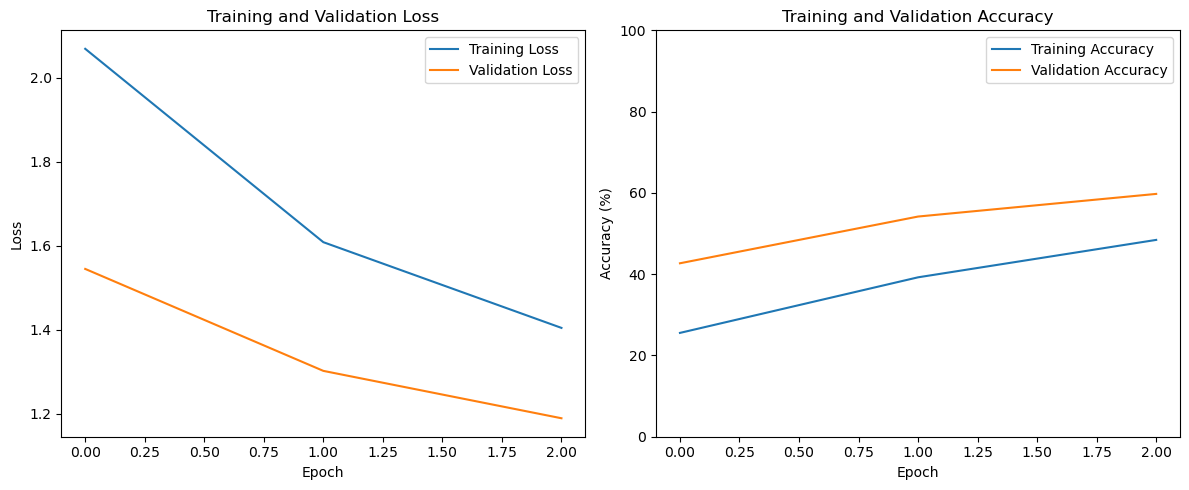

In [22]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# 3.3

In [30]:
# defining out CNN

class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # 1x1 conv branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU()
        )

        # 1x1 -> 3x3
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 1x1 -> 5x5
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU()
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        # concat along channel dimension
        outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)
        return outputs

class InceptionNN(nn.Module):
    def __init__(self):
        super().__init__()

        # input is 150 x 150 x 3

        self.inception = nn.Sequential(
            InceptionBlock(in_channels=3), # 150 x 150 x 3
            nn.MaxPool2d(kernel_size=2, stride=2), # 75 x 75 x 160 (32 + 64 + 32 + 32) 
            InceptionBlock(in_channels=160), # 75 x 75 x 160
            nn.MaxPool2d(kernel_size=2, stride=2), # 37 x 37 x 160
            InceptionBlock(in_channels=160),  # 37 x 37 x 160
            nn.MaxPool2d(kernel_size=2, stride=2), # 18 x 18 x 160
            
        )

        self.fc = nn.Sequential(
            nn.Linear(160 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 10) # 10 output classes for CIFAR-10
        )

        self.flatten = nn.Flatten()
        

    def forward(self, x):
        # conv layers with norm and pooling
        x = self.inception(x)

        # flatten
        x = self.flatten(x)

        # feed into fc layer
        x = self.fc(x)

        return x


In [31]:
model = InceptionNN().to(device)

print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

InceptionNN(
  (inception): Sequential(
    (0): InceptionBlock(
      (branch1x1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (branch3x3): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (branch5x5): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU()
      )
      (branch_pool): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): InceptionBlock(
      (branch1x1): Sequential(
        (0): Conv

In [32]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training loss and accuracy for this epoch
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}%')

    # Evaluate the model on the validation set
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute validation loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation loss and accuracy for this epoch
    val_loss /= len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Accuracy: {val_accuracy}%')

torch.save(model.state_dict(), '3model.pth')

KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
